# Load data and library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_val_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn import preprocessing

from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.tokenize.treebank import TreebankWordDetokenizer

from string import punctuation
import re

import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast

# specify GPU
device = torch.device("cuda")


df_raw = pd.read_csv("utterance-channel-dataset.csv")

# EDA

In [4]:
# Check label summary
label_summary = df_raw.groupby(['Channel']).agg({'Utterance': 'count',
                                           'ID':lambda x: np.round(x.count()/len(df_raw)*100,2)}) \
                .rename(columns={'Utterance':'Label Count','ID':'Percentage'}) \
#                 .sort_values(by='Label Count',ascending=False)
# label_summary

# Word count summary
cv = CountVectorizer()
wc = cv.fit_transform(df_raw['Utterance'])

df_wc = pd.DataFrame.sparse.from_spmatrix(wc, columns= cv.get_feature_names())

df_wc_channel = pd.DataFrame({'Word Count':df_wc.sum(axis=1),'Channel':df_raw['Channel']})

# count words by channel
wc_summary = df_wc_channel.groupby('Channel').describe()
# wc_summary.columns = wc_summary.columns.droplevel(0)
wc_summary[('Word Count', 'count')] = df_wc_channel.groupby("Channel").sum()
# wc_summary

# Combine summary
summary = pd.concat([label_summary,wc_summary],axis=1)
summary

,Label Count,Percentage,"(Word Count, count)","(Word Count, mean)","(Word Count, std)","(Word Count, min)","(Word Count, 25%)","(Word Count, 50%)","(Word Count, 75%)","(Word Count, max)"
Channel,,,,,,,,,,
General,23,7.67,987,42.913043,31.026254,13.0,20.50,34.0,55.50,116.0
Introduction,35,11.67,797,22.771429,18.763365,4.0,10.50,17.0,30.50,84.0
Off-topic,61,20.33,549,9.000000,9.823441,1.0,3.00,5.0,11.00,44.0
Resources,35,11.67,750,21.428571,16.398145,1.0,9.50,18.0,28.50,73.0
Resume Review,25,8.33,1077,43.080000,80.962913,2.0,10.00,19.0,33.00,333.0
community-requests,40,13.33,974,24.350000,17.989384,5.0,9.00,20.0,34.25,94.0
general-questions,42,14.00,1820,43.333333,42.908676,0.0,14.25,34.5,56.25,248.0
member-generated-content,39,13.00,1531,39.256410,26.243513,2.0,20.00,35.0,51.00,127.0


In [5]:
# Check top 100 words in each channel
top100 = []
allwords = {}
for i in set(df_raw['Channel']):
    cv = CountVectorizer(ngram_range=(1, 3))
    channel_wc = cv.fit_transform(df_raw[df_raw['Channel'] == i]['Utterance'])
    df_ct_general = pd.DataFrame.sparse.from_spmatrix(channel_wc, columns= cv.get_feature_names())
    general_mean = df_ct_general.sum(axis=0)#.mean(axis=0)
#     general_mean.sort_values(ascending=False)
    top100.append(list(general_mean.nlargest(100).index.array))
    allwords.update({i:general_mean.sort_values(ascending=False)})
#     print(i, general_mean.nlargest(100))

In [6]:
# Find top 100 words that appear in all channel 
# Can be use to create stop words 
checkset = set(top100[0]).intersection(set(top100[1]))
for i in range(7):
    checkset.update(checkset.intersection(set(top100[i+1])))
checkset

{'about',
 'all',
 'am',
 'an',
 'and',
 'as',
 'but',
 'can',
 'data',
 'do',
 'for',
 'from',
 'have',
 'here',
 'hi',
 'in',
 'into',
 'is',
 'it',
 'just',
 'learning',
 'like',
 'my',
 'of',
 'on',
 'the',
 'this',
 'to',
 'with',
 'you'}

In [7]:
# Check words appear more than 2 times in each channel

top = []
for i in set(df_raw['Channel']):
    cv = CountVectorizer(ngram_range=(1, 3))
    channel_wc = cv.fit_transform(df_raw[df_raw['Channel'] == i]['Utterance'])
    df_ct_general = pd.DataFrame.sparse.from_spmatrix(channel_wc, columns= cv.get_feature_names())
    general_mean = df_ct_general.sum(axis=0)#.mean(axis=0)
#     general_mean.sort_values(ascending=False)
    top.append(list(general_mean[general_mean > 1].index.array))
#     print(i, general_mean[general_mean>1])

# Find words that appear in all channel 
checkset2 = set(top100[0]).intersection(set(top100[1]))
for i in range(7):
    checkset2.update(checkset2.intersection(set(top100[i+1])))
    
# Same as top 100 words result
print('Two sets are the same:',checkset == checkset2)


Two sets are the same: True


In [8]:
# Check words in all channels
for i in set(df_raw['Channel']):
    print(allwords[i])

the                83
to                 63
and                46
of                 37
is                 33
                   ..
question in         1
query takes the     1
query takes         1
query               1
01                  1
Length: 3989, dtype: int64
and                35
to                 27
from               21
in                 20
am                 20
                   ..
myself in those     1
méxico              1
nairobi             1
nairobi kenya       1
4g                  1
Length: 1725, dtype: int64
you                        53
to                         35
your                       32
and                        26
that                       23
                           ..
repost it if                1
required                    1
required getting            1
required getting little     1
03                          1
Length: 2290, dtype: int64
to                      24
any                     18
and                     18
for                     

In [9]:
# Check post length less than 3
# Are these posts useful?
df_raw[df_wc.sum(axis=1) < 3]

,Utterance,Channel,ID
63,?,general-questions,64
68,any ideas?,general-questions,69
172,Samiksha Bhavsar,member-generated-content,173
184,Thats cool,Off-topic,185
186,oh,Off-topic,187
192,any breakthrough?,Off-topic,193
193,bahaha,Off-topic,194
196,damn covid,Off-topic,197
198,doesn't work,Off-topic,199
200,for real,Off-topic,201


In [10]:
# Find post with url
httppatern = re.compile(r'http\S+') 
pattern = []
for i in df_raw['Utterance']:
    pattern.append(bool(httppatern.search(i)))
    
df_raw[pattern]
# Most of them are in the member-generated-content

,Utterance,Channel,ID
6,FAQ Update We've updated the Frequently Asked ...,community-requests,7
7,February data review We've published our Febru...,community-requests,8
25,Privacy policy updates We've made some amendme...,community-requests,26
34,We have merged a new command to @Sir Lancebot:...,community-requests,35
40,@everyone I’m having an awesome time organizin...,General,41
101,right now I've tried random slices of data fro...,general-questions,102
141,10 python hacks you must know : https://datama...,member-generated-content,142
143,Chatbots have always been so fascinating to me...,member-generated-content,144
145,Finished my article on the scalping market for...,member-generated-content,146
147,"hello everyone, you can check out my article a...",member-generated-content,148


In [11]:
# Check weird token
for i in df_wc.columns:
    if len(i)> 8:
        print(i)

1319185184739061760
2d5085b9e12f
41q9lkhiz9y
4ceb50b84d164541bd5b0b7046aa7e6a
4d443da2ef7d
7357c07d8356
74d03f5707b3b48f5d8a4c7a07299b85
771a641c4a48
84382d068d78
87626aab3da3
9a2e303d3332
_one_page2
abdurahman
absolutely
activities
actuarial
additional
addresses
administrator
admissions
advertising
algorithm
algorithmic
algorithms
alleviating
alternative
amendments
analytics
analyticsvidhya
annotation
announcements
anonymously
appealing
application
applications
appreciate
appreciated
appreciates
architecture
artificial
assignments
astronomy
attention
attentions
authorship
automation
availability
available
b3bcb060580
bachelors
background
basically
batch_size
bathymetry
bb58975e148e4c768c2f09d416baf4d2
bd57fb8be888
beanlearning
beautiful
beforehand
beginners
beginning
beneficial
betterloader
branching
breakthrough
burcukoculu
calculating
captioning
capturing
catastrophic
categorising
celebrate
certainly
certification
certifications
certified
charlesaverill
clarification
class_mode
clas

In [28]:
# Check words that only appears once 
for i in df_wc.sum()[df_wc.sum() < 2].index:
    print(i)
    
# this may get a idea how to fix some of the words

01
02
1319185184739061760
14
15
16
17
1st
20
200
2019
2020
2025
28
28th
297e
2c3k
2d
2d5085b9e12f
2nd
30
33
3ish
3rd
400
41q9lkhiz9y
461
4ceb50b84d164541bd5b0b7046aa7e6a
4d443da2ef7d
4g
4k
4th
5000
615k
6900
700kwh
7357c07d8356
74d03f5707b3b48f5d8a4c7a07299b85
771a641c4a48
84382d068d78
87626aab3da3
93
944k
95
9a2e303d3332
_one_page2
aaic
abdullah
abdurahman
above
account
acg
achieve
act
activities
actuarial
added
addition
address
adjacent
admins
admissions
ads
advertising
advisors
af
afraid
ag
ago
ah
ahead
aim
alcohol
algo
algorithmic
algorithms
alleviating
allowed
allows
already
alright
ama
amendments
analytics
analyticsvidhya
andre
aniket
annotation
announcements
annoying
anomaly
anonymously
antonai
anuj
anybody
appealing
appended
appreciates
approx
apps
area
areas
aren
ariel
arrival
arrivals
arriving
artur
askers
asking
assess
assignments
astronomy
ats
attention
attentions
authorship
availability
average
avg
avoid
aware
awful
aws
axes
b01
b2b
b3bcb060580
bachelors
backend
bad
bag
ba

In [320]:
# New token pattern
cv = CountVectorizer()
cv.fit_transform(df_raw['Utterance'].iloc[6:7])

print(cv.get_feature_names())

cv2 = CountVectorizer(token_pattern = '[a-zA-Z0-9$&+,:;=?@#|<>.^*()%!-]+')
cv2.fit_transform(df_raw['Utterance'].iloc[6:7])

print(cv2.get_feature_names())

def Diff(li1, li2):
    return (list(list(set(li1)-set(li2)) + list(set(li2)-set(li1))))

print(Diff(cv.get_feature_names(),cv2.get_feature_names()))

['about', 'and', 'around', 'asked', 'centers', 'com', 'common', 'community', 'faq', 'frequently', 'get', 'https', 'link', 'now', 'on', 'our', 'page', 'pages', 'pythondiscord', 'questions', 'server', 'tag', 'the', 'this', 'to', 'update', 'updated', 've', 'we', 'webpage', 'website', 'will']
['!faq', 'about', 'and', 'around', 'asked', 'centers', 'common', 'community.', 'faq', 'frequently', 'frequently-asked-questions', 'get', 'https:', 'link', 'now', 'on', 'our', 'page', 'pages', 'pythondiscord.com', 'questions', 'server', 'tag', 'the', 'this', 'to', 'update', 'updated', 've', 'we', 'webpage.', 'website:', 'will']
['community', 'website', 'pythondiscord', 'https', 'com', 'webpage', '!faq', 'frequently-asked-questions', 'https:', 'pythondiscord.com', 'community.', 'website:', 'webpage.']


## Create stop words

In [118]:
# Based on the checkset above 
custStopList = ['all', 'and', 'as', 'be', 'can', 'everyone', 'for', 'have', 'if', 'in', 'it', 'just',
 'like', 'me', 'of', 'on', 'or', 'some', 'that', 'the', 'this', 'to', 'with', 'would', 'you']

customStopWords = set(stopwords.words('english')+custStopList)
ls_remove = ['how','what','when','who','why']
customStopWords.difference_update(ls_remove)

### Remove stop words

In [116]:
customStopWords = set(stopwords.words('english')+list(punctuation))
ls_remove = ['?', 'how','what','when','who','why']
customStopWords.difference_update(ls_remove)

wnl = WordNetLemmatizer()
porter_stemmer = PorterStemmer()

## Clean up text

In [7]:
# Check stemming 
df_word_cleaned = []

for i in df_raw['Utterance']:
    wordtokenList = [word for word in word_tokenize(new_sent)]

Separate Category for the Weekly Topic To better highlight the weekly topic, we've moved the weekly topic channel to a separate channel. This also allowed us to have two separate text channels, one highlighting the topic (#weekly-topic) and one for discussing the topic (#weekly-topic-discussion).(edited)
hey, i would like to ask if it's possible to get the channel where users exchanged projects back
Any update on my ModMail about the hackathon?
@Admins I have a suggestion. Python has some music libraries and also some great features like MIDI Handling. It would be a good idea if we opened a music in python topic channel.
Can we have a beginner channel
Channel Rename We've changed #async-and-concurrency from #async to what it is currently. This is to better indicate that all concurrency topics (i.e. threads, trio, twisted, multiprocessing, GIL) belong in this topical channel, not just async.
FAQ Update We've updated the Frequently Asked Questions page on our website: https://pythondisco

In [ ]:
# Check Lemmatisation

In [114]:
def cleanText(text):
    df_word_cleaned = []
    for i in range(len(text)):
        new_sent = re.sub(r'\d+', '', text.iloc[i]).lower() #remove numbers
        new_sent = re.sub(r'http\S+', '', new_sent) # remove url
        wordtokenList = [word for word in word_tokenize(new_sent)]
        wordNoStopList = [word for word in wordtokenList if word not in customStopWords]
        lemList = [wnl.lemmatize(word) for word in wordNoStopList]
        df_word_cleaned.append([porter_stemmer.stem(word) for word in lemList])
    # re-assemble the token back to sentence form 
    cleaned_sent = []
    for sentence in df_word_cleaned:
        cleaned_sent.append(TreebankWordDetokenizer().detokenize(sentence))
    cleaned_sent
    
    return cleaned_sent


### Get TF

In [12]:
cv = CountVectorizer()
tf = cv.fit_transform(cleaned_sent)
df_tf = pd.DataFrame.sparse.from_spmatrix(tf, columns= cv.get_feature_names())#.to_csv("tf.csv")
df_tf

### Get TF-IDF

In [29]:
vectorizer = TfidfVectorizer(min_df = 3,ngram_range = (1,3))
transformed_documents = vectorizer.fit_transform(df_raw['Utterance'])
# transformed_documents = vectorizer.fit_transform(cleanText(df_raw['Utterance']))
df_transform_documents = pd.DataFrame.sparse.from_spmatrix(transformed_documents, columns=vectorizer.get_feature_names())#.to_csv('cleanedminTF3ng3.csv')
df_transform_documents

,10,2021,able,able to,about,about ai,actually,add,adding,advanced,...,you guys,you have,you re,you recommend,you should,you think,you to,you want,your,your resume
0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.00000,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000
1,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.00000,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000
2,0.0,0.0,0.0,0.0,0.347712,0.0,0.0,0.000000,0.00000,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000
3,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.00000,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000
4,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.00000,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.00000,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000
296,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.00000,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000
297,0.0,0.0,0.0,0.0,0.026514,0.0,0.0,0.078043,0.04224,0.0,...,0.0,0.167594,0.107408,0.0,0.0,0.040469,0.0,0.0,0.304612,0.183688
298,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.00000,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000


In [30]:
# This cannot replace 0 with nan due to "pd.DataFrame.sparse.from_spmatrix" stored columns as sparse matrix
df_transform_documents.mean(axis=0)#.sort_values(ascending=False)[0:60]


10             0.003264
2021           0.004097
able           0.001416
able to        0.001416
about          0.013907
                 ...   
you think      0.002372
you to         0.001870
you want       0.002660
your           0.018666
your resume    0.004428
Length: 756, dtype: float64

In [50]:
df_tfidf.replace(0, np.NaN).mean(axis=0).sort_values(ascending=False)

showusyourdog    1.000000
lmao             1.000000
bahaha           1.000000
showmeyourdog    1.000000
breakthrough     0.890691
                   ...   
mile             0.045750
creative         0.045750
definitely       0.044400
looks            0.044400
faraz            0.044400
Length: 2060, dtype: float64

In [31]:
vectorizer2 = TfidfVectorizer(stop_words='english')
transformed_documents2 = vectorizer2.fit_transform(df_raw['Utterance'])

In [32]:
len(vectorizer.get_feature_names())

756

### TF-IDF using cleaned text

In [24]:
vectorizer = TfidfVectorizer(min_df = 3,ngram_range = (1,3))
transformed_documents = vectorizer.fit_transform(cleaned_sent)

In [26]:
df_transform_document = pd.DataFrame.sparse.from_spmatrix(transformed_documents,columns=vectorizer.get_feature_names())
df_transform_document#.to_csv('Cleaned TFIDF.csv')

,abl,actual,ad,add,addit,address,admin,advanc,advic,agre,...,work,would,would like,write,written,wrote,yacov,ye,year,yet
0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
1,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.252394,0.36034,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
2,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
3,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.291326,0.0,0.0,0.0,...,0.000000,0.177472,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
4,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
296,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
297,0.0,0.0,0.070396,0.135757,0.073478,0.000000,0.000000,0.0,0.0,0.0,...,0.151735,0.000000,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
298,0.0,0.0,0.000000,0.000000,0.000000,0.483349,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.0,0.463078,0.0,0.0


# Modeling

In [61]:
X_train, X_test, y_train, y_test = train_test_split(
    df_raw, df_raw['Channel'], test_size=0.1)

In [62]:
vectorizer = TfidfVectorizer(min_df = 3, max_df = 0.6, ngram_range = (1,3))

In [63]:
clf = SVC()

In [64]:
transformed_documents = vectorizer.fit_transform(X_train['Utterance'])
df_transform_documents = pd.DataFrame.sparse.from_spmatrix(transformed_documents,columns=vectorizer.get_feature_names())

scores = cross_val_score(clf, df_transform_documents.values, y_train, cv=10, n_jobs=-1,scoring='accuracy')

In [65]:
scores

array([0.51851852, 0.55555556, 0.66666667, 0.59259259, 0.48148148,
       0.59259259, 0.55555556, 0.55555556, 0.59259259, 0.48148148])

In [66]:
transformed_documents

<270x708 sparse matrix of type '<class 'numpy.float64'>'
	with 5680 stored elements in Compressed Sparse Row format>

In [67]:
clf.fit(transformed_documents,y_train)
print("Trainning", clf.score(transformed_documents,y_train))

Trainning 0.9962962962962963


In [68]:
test_transfomend = vectorizer.transform(X_test['Utterance'])

In [69]:
print(clf.score(test_transfomend,y_test))

0.5666666666666667


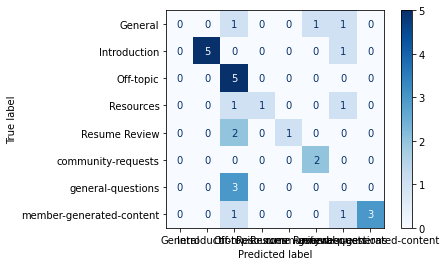

In [70]:
plot_confusion_matrix(clf, test_transfomend, y_test, cmap=plt.cm.Blues)  

### Test cleaned tf-idf

In [54]:
X_train, X_test, y_train, y_test = train_test_split(
    df_raw['Utterance'], df_raw['Channel'], test_size=0.2, random_state=42)

In [55]:
X_train

232                                       shOWUSYOURDOG.
59     Please keep this channel only for information ...
6      FAQ Update We've updated the Frequently Asked ...
185               Open a command prompt as administrator
173    Scikit-Learn Design with Easy Explanation I th...
                             ...                        
188    @Poppa isn't there a Finnish saying about, "if...
71              does anyone has any experience with mds?
106    Hei anuj, It seems we have same background. Ca...
270            what are good resources for learning nlp?
102    Something pretty like this one from the ResNet...
Name: Utterance, Length: 240, dtype: object

In [58]:
# X_train = cleanText(X_train)
vectorizer = TfidfVectorizer(min_df = 3, ngram_range = (1,3))
transformed_documents = vectorizer.fit_transform(X_train)

In [59]:
df_transform_document = pd.DataFrame.sparse.from_spmatrix(transformed_documents,columns=vectorizer.get_feature_names())

In [60]:
df_transform_document

,10,able,able to,about,about ai,actually,add,after,again,agree,...,you can,you do,you guys,you have,you re,you recommend,you to,you want,your,your resume
0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.137601,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.000000,0.0,0.262595,0.0,0.0,0.0,0.274614,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,0.0,0.0,0.0,0.290775,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
236,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
237,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
238,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [61]:
test_transfomend

<30x673 sparse matrix of type '<class 'numpy.float64'>'
	with 444 stored elements in Compressed Sparse Row format>

In [62]:
X_test = cleanText(X_test)
test_transfomend = vectorizer.transform(X_test)

In [63]:
clf = SVC(C=1)
clf.fit(transformed_documents,y_train)

SVC(C=1)

In [64]:
clf.score(transformed_documents,y_train)

0.9916666666666667

In [65]:
clf.score(test_transfomend,y_test)

0.4166666666666667

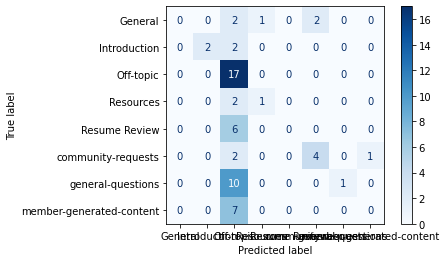

In [67]:
plot_confusion_matrix(clf, test_transfomend, y_test, cmap=plt.cm.Blues)  

In [68]:


print(classification_report(y_test, clf.predict(test_transfomend)))

                          precision    recall  f1-score   support

                 General       0.00      0.00      0.00         5
            Introduction       1.00      0.50      0.67         4
               Off-topic       0.35      1.00      0.52        17
               Resources       0.50      0.33      0.40         3
           Resume Review       0.00      0.00      0.00         6
      community-requests       0.67      0.57      0.62         7
       general-questions       1.00      0.09      0.17        11
member-generated-content       0.00      0.00      0.00         7

                accuracy                           0.42        60
               macro avg       0.44      0.31      0.30        60
            weighted avg       0.45      0.42      0.32        60



D:\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [227]:
confusion_matrix(y_test, clf.predict(test_transfomend)).ravel().reshape([8,8])

array([[ 2,  0,  1,  1,  0,  1,  0,  0],
       [ 0,  3,  1,  0,  0,  0,  0,  0],
       [ 0,  0, 14,  0,  0,  0,  2,  1],
       [ 0,  0,  0,  3,  0,  0,  0,  0],
       [ 0,  0,  2,  1,  1,  0,  0,  2],
       [ 0,  0,  0,  0,  0,  7,  0,  0],
       [ 0,  0,  8,  0,  0,  0,  3,  0],
       [ 0,  0,  1,  1,  0,  0,  1,  4]], dtype=int64)

## Pipeline and Utility Function

In [23]:

pipeline = Pipeline(steps=[
    ('tfidf', TfidfVectorizer()),
    ('svc', SVC())
])

parameters = {
#     'preprocessor':[],
#     'stop_words':[],
    'tfidf__ngram_range':[(1,1),(1,2),(1,3)],
    'tfidf__max_df':[1,.9,.8,.7,.6],
    'tfidf__min_df':[1,2,3,4,5],
#     'max_features':[],
    'svc__C':[1,.9,.7,.5,.2,.1],
    
}

# grid search
grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1)

X_train, X_test, y_train, y_test = train_test_split(
    df_raw['Utterance'], df_raw['Channel'], test_size=0.1, random_state=42)

grid_search.fit(X_train,y_train)

grid_search.best_score_

In [40]:
label.dtype

dtype('int32')

# BERT

In [2]:
le = preprocessing.LabelEncoder()

label = le.fit_transform(df_raw['Channel'])
# label = label.astype('long')

X_train, X_temp, y_train, y_temp = train_test_split(
    df_raw['Utterance'], label, test_size=0.4, random_state=412,stratify=label)


X_test, X_val, y_test, y_val = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=412,stratify=y_temp)

# import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased')

# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

In [3]:
# sample data
text = ["this is a bert model tutorial", "we will fine-tune a bert model"]

# encode text
# tokens_sa = tokenizer.batch_encode_plus(text, padding=True, return_token_type_ids=False,max_length=3)
tokens_sa = tokenizer.batch_encode_plus(text, padding=True,max_length=3,truncation=True)

In [4]:
train_seq = torch.tensor(tokens_sa['input_ids'])
train_mask = torch.tensor(tokens_sa['attention_mask'])
train_seq

tensor([[ 101, 2023,  102],
        [ 101, 2057,  102]])

<AxesSubplot:>

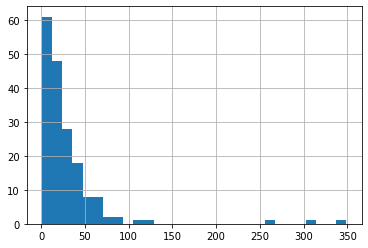

In [5]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in X_train]

pd.Series(seq_len).hist(bins = 30)



In [6]:
max_seq_len = 50

In [7]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    X_train.tolist(),
    max_length = max_seq_len,
    padding=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    X_val.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    X_test.tolist(),
    max_length = max_seq_len,
    padding=True,
    truncation=True,
    return_token_type_ids=False
)

In [8]:
# for train set
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(y_train)

# for validation set
val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(y_val.tolist())

# for test set
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(y_test.tolist())

In [9]:
print(train_mask.shape)
print(train_seq.shape)
print(train_y.shape)

torch.Size([180, 50])
torch.Size([180, 50])
torch.Size([180])


In [10]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 32

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

In [11]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

In [88]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):
        
      
        super(BERT_Arch, self).__init__()

        self.bert = bert 
      
        # dropout layer
        self.dropout = nn.Dropout(0.1)
      
        # relu activation function
        self.relu =  nn.ReLU()

        # dense layer 1
        self.fc1 = nn.Linear(768,30)
      
        # dense layer 2 
        self.fc2 = nn.Linear(30,8)
        
#         # dense layer 3
#         self.fc3 = nn.Linear(256,64)
      
#         # dense layer 4 (Output layer)
#         self.fc4 = nn.Linear(64,8)

        #softmax activation function
        self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):

        #pass the inputs to the model  
        _, cls_hs = self.bert(sent_id, attention_mask=mask)
      
        x = self.fc1(cls_hs)
        
        x = self.relu(x)
        
        x = self.dropout(x)

        x = self.fc2(x)
        
        x = self.relu(x)

#         x = self.fc3(x)

#         x = self.relu(x)

#         # output layer
#         x = self.fc4(x)
      
        # apply softmax activation
        x = self.softmax(x)

        return x



In [89]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)

# push the model to GPU
model = model.to(device)

In [90]:
# optimizer from hugging face transformers
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(), lr = 1e-3)

In [91]:
from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
class_wts = compute_class_weight('balanced', np.unique(y_train), y_train)

print(class_wts)

[1.60714286 1.07142857 0.60810811 1.07142857 1.5        0.9375
 0.9        0.97826087]


f:\ds git projects\aml-1\aml-1-venv\lib\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass classes=[0 1 2 3 4 5 6 7], y=[4 7 2 4 0 1 4 5 2 1 2 4 4 3 3 1 7 2 3 6 2 7 1 6 3 2 2 4 3 3 5 5 6 5 2 2 3
 1 2 6 1 6 3 2 1 5 4 6 2 6 4 1 6 7 2 5 2 7 5 5 3 2 2 2 5 2 5 7 7 6 5 2 2 3
 7 6 2 0 4 7 4 3 6 0 7 3 5 3 7 3 1 2 1 7 6 7 5 6 6 2 6 7 1 7 2 0 2 5 0 3 3
 5 1 5 4 7 6 0 3 0 2 7 2 5 3 0 6 0 3 5 1 2 5 6 2 6 7 1 5 6 2 2 7 0 1 1 4 6
 0 7 4 2 2 3 0 6 6 4 3 2 6 2 1 7 7 1 2 0 7 1 1 4 5 5 1 0 6 5 2 5] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


In [102]:


# convert class weights to tensor
weights= torch.tensor(class_wts,dtype=torch.float)
weights = weights.to(device)

# loss function
cross_entropy  = nn.NLLLoss(weight=weights) 
# cross_entropy  = nn.NLLLoss() 
# number of training epochs
epochs = 100



In [103]:
# function to train the model
def train():
    model.train()
    total_loss, total_accuracy = 0, 0
  
  # empty list to save model predictions
    total_preds=[]
  
  # iterate over batches
    for step,batch in enumerate(train_dataloader):
        # progress update after every 50 batches.
        if step % 50 == 0 and not step == 0:
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

        # push the batch to gpu
        batch = [r.to(device) for r in batch]

        sent_id, mask, labels = batch

        # clear previously calculated gradients 
        model.zero_grad()        

        # get model predictions for the current batch
        preds = model(sent_id, mask)

        # compute the loss between actual and predicted values
        loss = cross_entropy(preds, labels.to(torch.long))

        # add on to the total loss
        total_loss = total_loss + loss.item()

        # backward pass to calculate the gradients
        loss.backward()

        # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # update parameters
        optimizer.step()

        # model predictions are stored on GPU. So, push it to CPU
        preds=preds.detach().cpu().numpy()

        # append the model predictions
        total_preds.append(preds)

    # compute the training loss of the epoch
    avg_loss = total_loss / len(train_dataloader)
  
    # predictions are in the form of (no. of batches, size of batch, no. of classes).
    # reshape the predictions in form of (number of samples, no. of classes)
    total_preds  = np.concatenate(total_preds, axis=0)

    #returns the loss and predictions
    return avg_loss, total_preds

In [104]:
# function for evaluating the model
def evaluate():
    print("\nEvaluating...")
  
  # deactivate dropout layers
    model.eval()
    
    total_loss, total_accuracy = 0, 0
  
  # empty list to save the model predictions
    total_preds = []

  # iterate over batches
    for step,batch in enumerate(val_dataloader):
    
        # Progress update every 50 batches.
        if step % 50 == 0 and not step == 0:
      
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    # push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch

    # deactivate autograd
    with torch.no_grad():
        # model predictions
        preds = model(sent_id, mask)
        # compute the validation loss between actual and predicted values
        loss = cross_entropy(preds,labels)
        
        total_loss = total_loss + loss.item()

        preds = preds.detach().cpu().numpy()

        total_preds.append(preds)

    # compute the validation loss of the epoch
    avg_loss = total_loss / len(val_dataloader) 

    # reshape the predictions in form of (number of samples, no. of classes)
    total_preds  = np.concatenate(total_preds, axis=0)

    return avg_loss, total_preds

In [105]:
# set initial loss to infinite
best_test_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
val_losses=[]

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _ = train()
    
    #evaluate model
    val_loss, _ = evaluate()
    
    #save the best model
    if val_loss < best_test_loss:
        best_test_loss = val_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {val_loss:.3f}')


 Epoch 1 / 100

Evaluating...

Training Loss: 1.913
Validation Loss: 0.945

 Epoch 2 / 100

Evaluating...

Training Loss: 1.864
Validation Loss: 0.959

 Epoch 3 / 100

Evaluating...

Training Loss: 1.882
Validation Loss: 0.996

 Epoch 4 / 100

Evaluating...

Training Loss: 1.838
Validation Loss: 0.991

 Epoch 5 / 100

Evaluating...

Training Loss: 1.781
Validation Loss: 0.946

 Epoch 6 / 100

Evaluating...

Training Loss: 1.803
Validation Loss: 0.963

 Epoch 7 / 100

Evaluating...

Training Loss: 1.800
Validation Loss: 0.965

 Epoch 8 / 100

Evaluating...

Training Loss: 1.856
Validation Loss: 0.963

 Epoch 9 / 100

Evaluating...

Training Loss: 1.835
Validation Loss: 0.953

 Epoch 10 / 100

Evaluating...

Training Loss: 1.813
Validation Loss: 0.967

 Epoch 11 / 100

Evaluating...

Training Loss: 1.819
Validation Loss: 0.974

 Epoch 12 / 100

Evaluating...

Training Loss: 1.812
Validation Loss: 0.945

 Epoch 13 / 100

Evaluating...

Training Loss: 1.787
Validation Loss: 0.959

 Epoch 

In [108]:
#load weights of best model
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [109]:
# get predictions for test data
with torch.no_grad():
    preds = model(test_seq.to(device), test_mask.to(device))
    preds = preds.detach().cpu().numpy()

In [110]:
# model's performance
preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.33      0.75      0.46         4
           1       0.40      0.86      0.55         7
           2       0.70      0.58      0.64        12
           3       0.00      0.00      0.00         7
           4       0.33      0.80      0.47         5
           5       0.14      0.12      0.13         8
           6       0.00      0.00      0.00         9
           7       0.86      0.75      0.80         8

    accuracy                           0.45        60
   macro avg       0.35      0.48      0.38        60
weighted avg       0.37      0.45      0.39        60



f:\ds git projects\aml-1\aml-1-venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
f:\ds git projects\aml-1\aml-1-venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
f:\ds git projects\aml-1\aml-1-venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [111]:
preds

array([4, 4, 4, 0, 4, 4, 1, 7, 4, 5, 7, 1, 2, 0, 5, 1, 2, 7, 0, 5, 1, 0,
       0, 1, 5, 5, 1, 2, 1, 1, 4, 7, 4, 4, 5, 1, 4, 2, 7, 5, 0, 0, 1, 2,
       4, 2, 4, 1, 2, 1, 7, 0, 0, 2, 2, 1, 1, 1, 7, 2], dtype=int64)

In [112]:
# confusion matrix
pd.crosstab(test_y, preds)

col_0,0,1,2,4,5,7
row_0,,,,,,
0,3,0,0,0,1,0
1,0,6,0,1,0,0
2,0,0,7,3,2,0
3,0,5,1,0,1,0
4,1,0,0,4,0,0
5,2,0,1,3,1,1
6,2,3,1,1,2,0
7,1,1,0,0,0,6


In [113]:
confusion_matrix(y_test, preds)

array([[3, 0, 0, 0, 0, 1, 0, 0],
       [0, 6, 0, 0, 1, 0, 0, 0],
       [0, 0, 7, 0, 3, 2, 0, 0],
       [0, 5, 1, 0, 0, 1, 0, 0],
       [1, 0, 0, 0, 4, 0, 0, 0],
       [2, 0, 1, 0, 3, 1, 0, 1],
       [2, 3, 1, 0, 1, 2, 0, 0],
       [1, 1, 0, 0, 0, 0, 0, 6]], dtype=int64)